In [3]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from pathlib import Path
import pandas_datareader as web
import requests
from dotenv import load_dotenv
import os
import pprint
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2
from MCForecastTools import MCSimulation

In [4]:
# Read the Historical financial Data
historical_financial_df = web.get_data_yahoo(['^GSPC','CL=F','BTC-USD'], '10/31/2017', interval='d')
historical_financial_df = historical_financial_df.iloc[:, [0,1,2]]
historical_financial_df.dropna(inplace=True)

# Display Sample
historical_financial_df.head()

Attributes    Adj Close                        
Symbols           ^GSPC       CL=F      BTC-USD
Date                                           
2017-10-31  2575.260010  54.380001  6468.399902
2017-11-01  2579.360107  54.299999  6767.310059
2017-11-02  2579.850098  54.540001  7078.500000
2017-11-03  2587.840088  55.639999  7207.759766
2017-11-06  2591.129883  57.349998  7022.759766

In [5]:
# Reading Weather Data and combining with dailly returns of the historical_financial_df

# Original weather data obtained from Weatherbit.io API and saved as a csv to stave on limited request
# For API code see README.md
weather_data_path = Path('./weather_data_4years.csv')
weather_df = pd.read_csv(weather_data_path, index_col="Date", infer_datetime_format=True, parse_dates=True)

# Add Average Temp Column
col = weather_df.loc[:,"High_Temp":"Low_Temp" ]
weather_df['Average_Temp'] = col.mean(axis=1)


# Create Daily Returns 
daily_returns = historical_financial_df.pct_change(fill_method='ffill')
daily_returns.dropna()

# Cleans column naming
daily_returns.columns = [' '.join(col).strip() for col in daily_returns.columns.values]
columns = ["sp_500", "WTI", "BTC"]
daily_returns.columns = columns

# Combines the daily returns with weather data
combined_df = pd.concat([daily_returns, weather_df['Average_Temp'],], axis="columns", join="inner")
combined_df.head()

# Display Sample
combined_df.head()

,sp_500,WTI,BTC,Average_Temp
Date,,,,
2018-10-31,0.010851,-0.013146,-0.002630,12.40
2018-11-01,0.010558,-0.024805,0.009524,16.60
2018-11-02,-0.006317,-0.008636,0.001671,19.00
2018-11-05,0.005600,-0.000634,0.004887,11.00
2018-11-06,0.006259,-0.014105,0.006441,12.95


<AxesSubplot:xlabel='Date'>

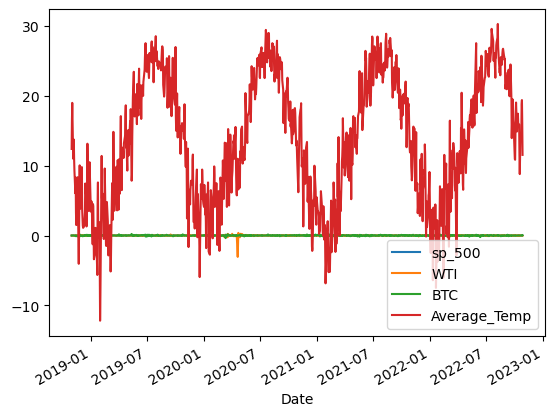

In [6]:
# Create and view initial plot
combined_df.plot()

# Above temperature correlation assessment
NYC temperature obviously follows a predictable pattern over the course of 4 years
However the scale of daily returns is so small that its pretty challenging to observe any potential correletion
Option to rescale so that is -- completed in data_collection.ipynb but did not display any observable 

## If we compare just the S&P 500 and the average temperature, what relationship do we observe?

Text(0, 0.5, 'Average_Temp')

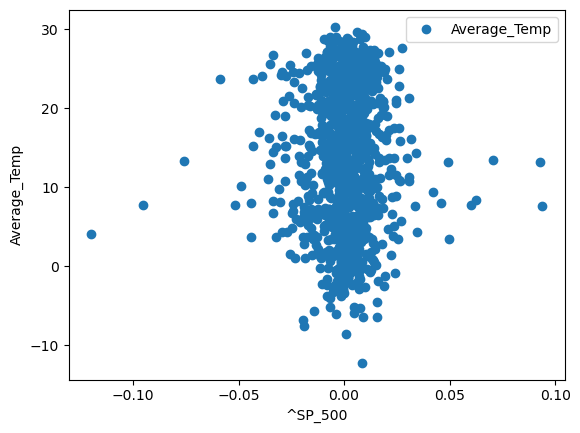

In [7]:
combined_df.plot(x='sp_500', y= 'Average_Temp', style= 'o')
plt.xlabel ('^SP_500')
plt.ylabel ('Average_Temp')

<AxesSubplot:>

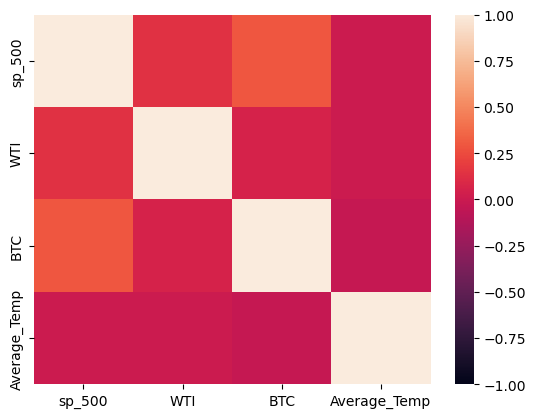

In [8]:
# Calculate and display de correlation matrix
correlation = combined_df.corr()
sns.heatmap(correlation, vmin=-1, vmax=1)

## The above heatmap shows show quantifiable figures indicating that weather is almost completely uncorrelated with the market as well as oil and BTC as specific assets.
The only observable correlations accoding to the heatmap is between the S&P 500 and BTC-USD. 
So plotting that below.
But that graph is not very descriptive because of how many data points and how.
### So one of the questions remaining, would the correlation of approximately 0.25 be more observable between S&P 500 and BTC-USD if we were to look a the returns on a month by moth basis rather than daily?

In [9]:

sp500_btc_comparision = combined_df.drop(columns=['WTI'])
sp500_btc_comparision.hvplot.line(
    x='Date',
    y=['sp_500', 'BTC'],
    xlabel='Year',
    ylabel="Return",
    title="Sale Price Per Square Foot and Average Gross Rent - 2010-2016 - San Francisco"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# Sentiment Correlation

## Function created and imported from
`from ipynb.fs.full.pytrends_sentiment import generate_trends_analysis, generate_trends_analysis2`

SPY:2022-09-01 2022-09-30
SPY:2022-10-01 2022-10-31
SPY:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'SPY Daily Return Correlation with Sentiment Plot'}>

(None, None)

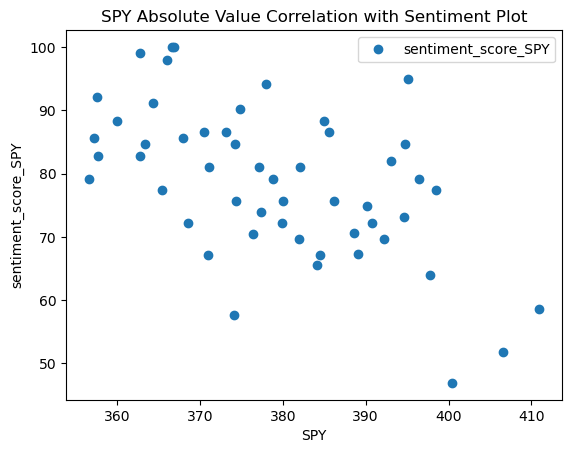

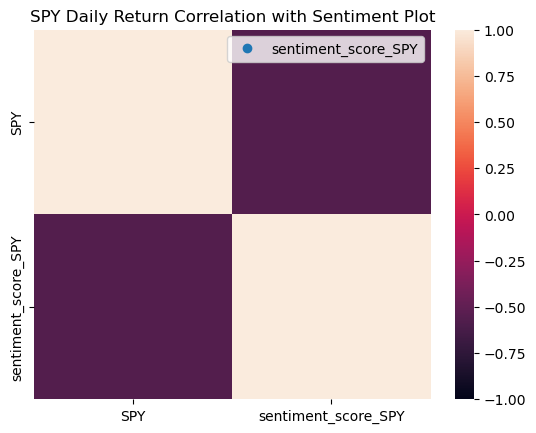

In [10]:
"""
The below chart of ABS value indicates a negative correlation between google search trends.
In pytrends_sentiment.ipynb the function displays the heatmap. but here it is not.
"""

generate_trends_analysis2('SPY')

BTC-USD:2022-09-01 2022-09-30
BTC-USD:2022-10-01 2022-10-31
BTC-USD:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'BTC-USD Daily Return Correlation with Sentiment Plot'}>

(None, None)

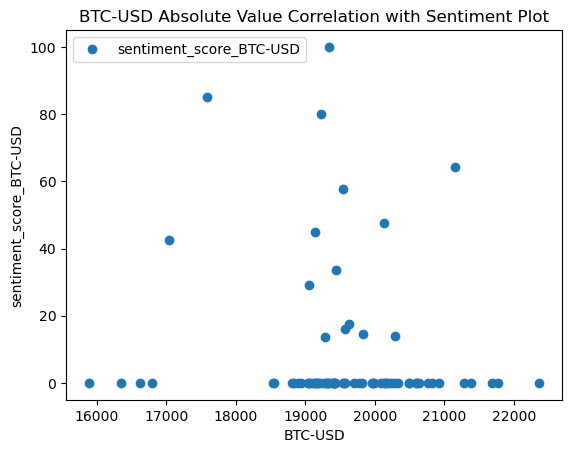

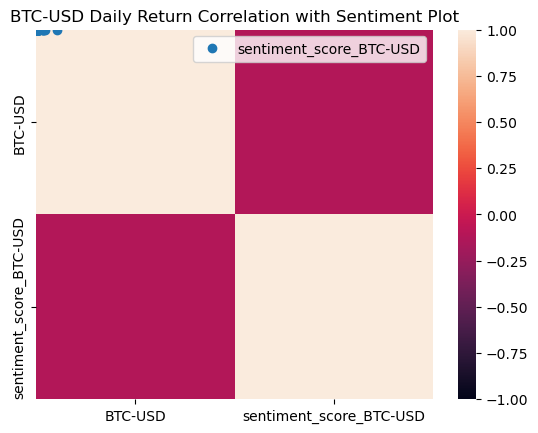

In [11]:
# Bitcoin price plot with Google Trends sentiment score
generate_trends_analysis2('BTC-USD')

CL=F:2022-09-01 2022-09-30
CL=F:2022-10-01 2022-10-31
CL=F:2022-11-01 2022-11-30


<AxesSubplot:title={'center':'CL=F Daily Return Correlation with Sentiment Plot'}>

<AxesSubplot:title={'center':'CL=F Daily Return Correlation with Sentiment Plot'}>

(None, None)

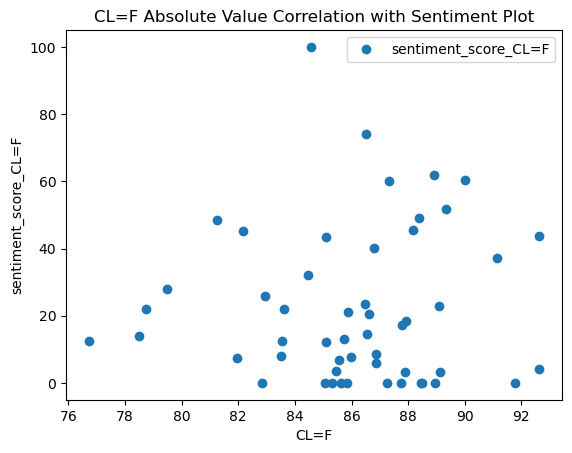

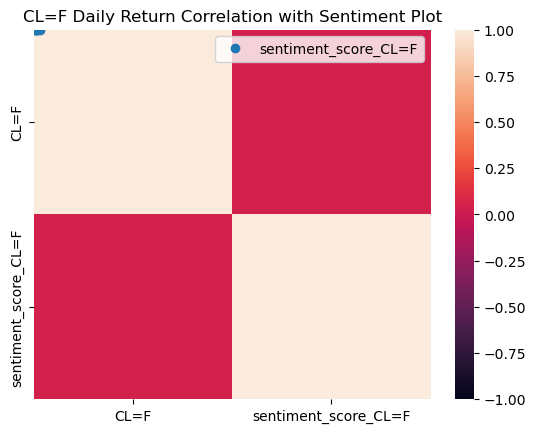

In [12]:
# Oil ETF price plot with Google Trends sentiment score
generate_trends_analysis2("CL=F")

# Portfolio Analysis
## Would a portfolio made up of SP500 index fund, BTC and Oil be balanced and perform well over time

To answer this question, we started with looking at the cumulative returns, then proceeded with risk assessment of the various assets.


<AxesSubplot:xlabel='Date'>

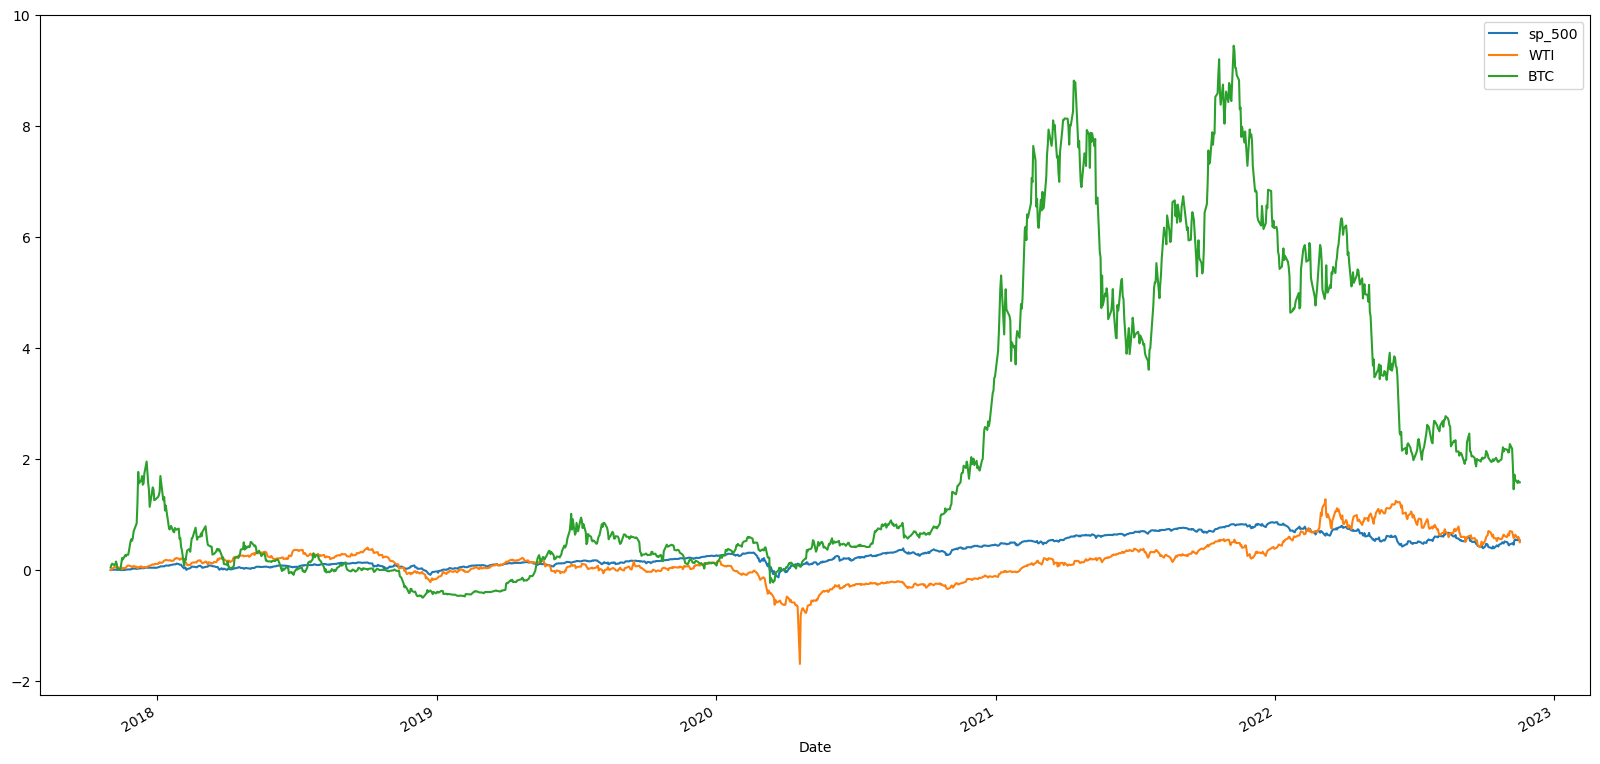

In [13]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + daily_returns).cumprod() - 1
# Plot cumulative returns
cumulative_returns.plot(figsize=(20,10))

In [14]:
# Callculate the daily standard deviations as a measure of risk
assets_std = daily_returns.std().sort_values()
assets_std

sp_500    0.013603
BTC       0.047655
WTI       0.098914
dtype: float64

<AxesSubplot:>

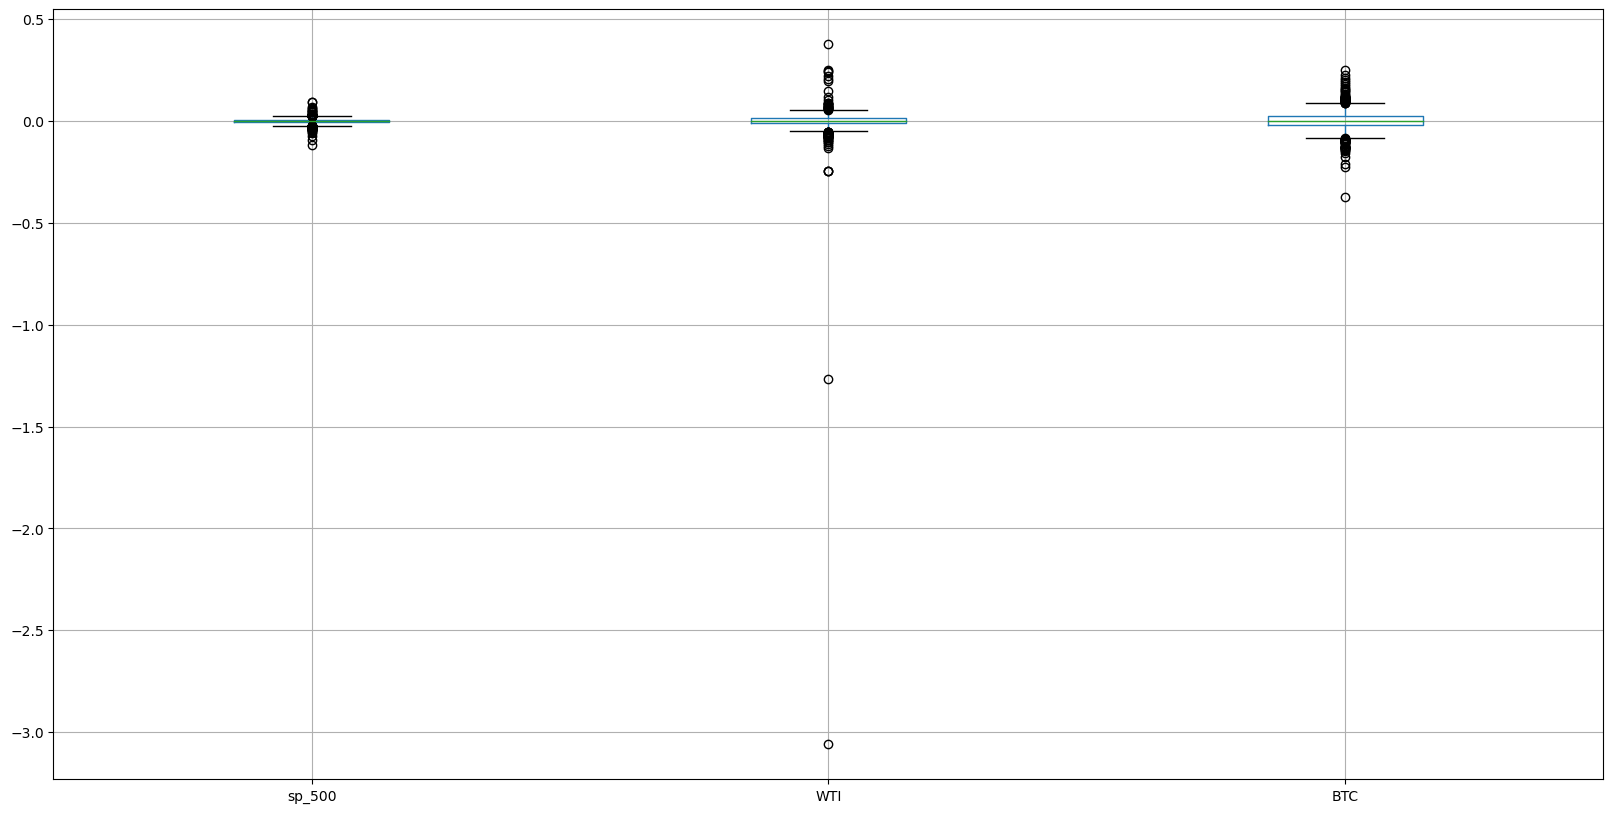

In [15]:
# Box plot to visually show risk
daily_returns.boxplot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

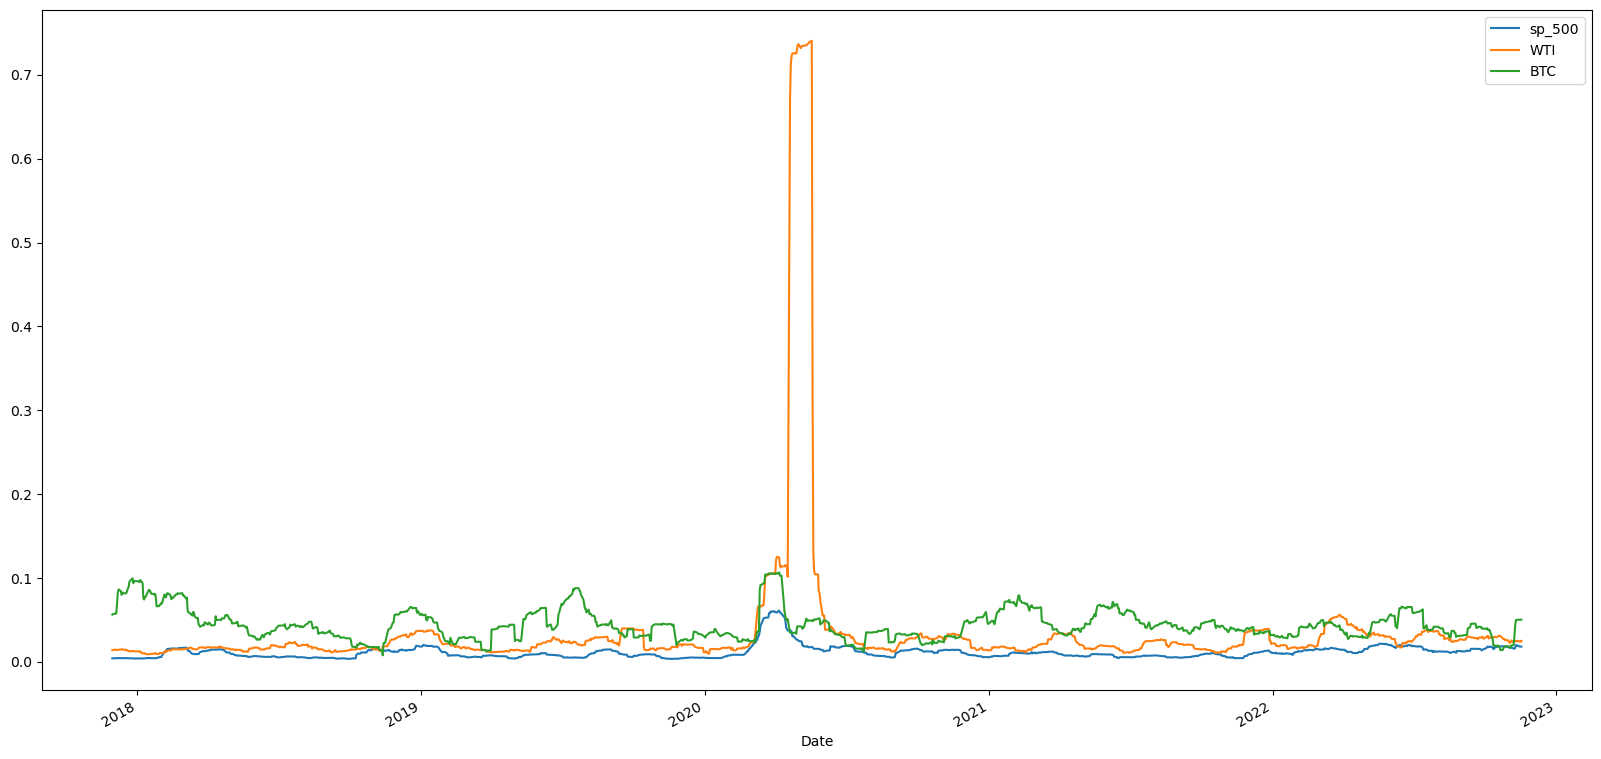

In [16]:
# callculate the rolling statandard deviation for 
rolling_21day_std_df = daily_returns.rolling(window=21).std()
# Plot the rolling standard deviation
rolling_21day_std_df.plot(figsize=(20,10))

# Covariance tells us the risk relative to the overall market. 

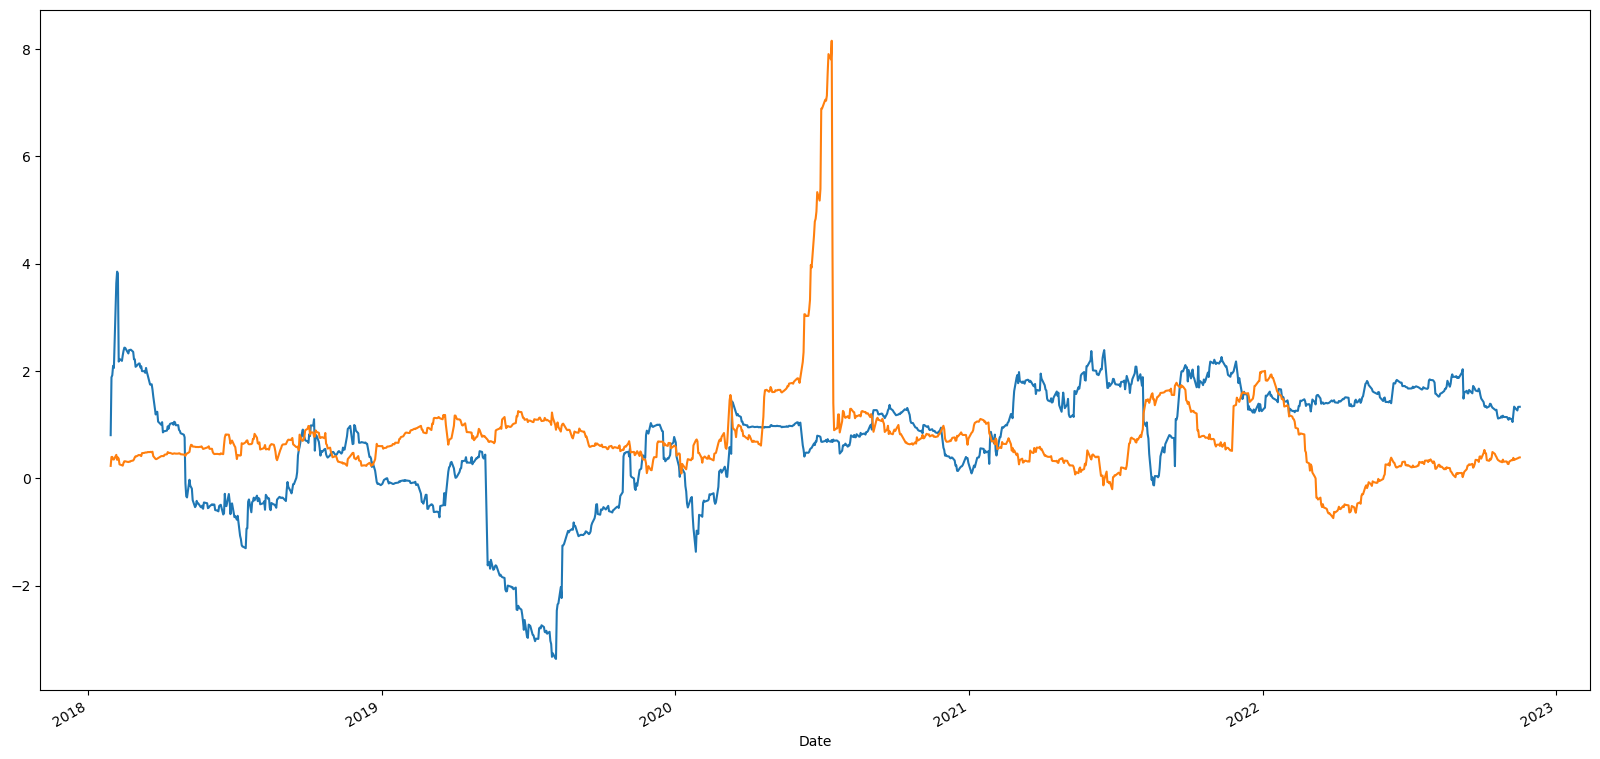

In [17]:
# Calculate covariance of a BTC
BTC_covariance = daily_returns["BTC"].rolling(window=60).cov(daily_returns["sp_500"])

# Calculate variance of S&P 500
variance = daily_returns["sp_500"].rolling(window=60).var()
# Computing beta
BTC_beta = BTC_covariance/variance
# Plot beta trend
BTC_plot = BTC_beta.plot(figsize=(20, 10))

# Calculate covariance of a WTI
WTI_covariance = daily_returns["WTI"].rolling(window=60).cov(daily_returns["sp_500"])
# Computing beta
WTI_beta = WTI_covariance/variance
# Plot beta trend
WTI_plot = WTI_beta.plot(figsize=(20, 10))

# BTC_plot * WTI_plot
# BTC_plot 
# BTC_plot * WTI_plot

# Note BTC is in Blue and Oil is in Orange
# BTC_plot


<AxesSubplot:title={'center':'Sharpe Ratios'}>

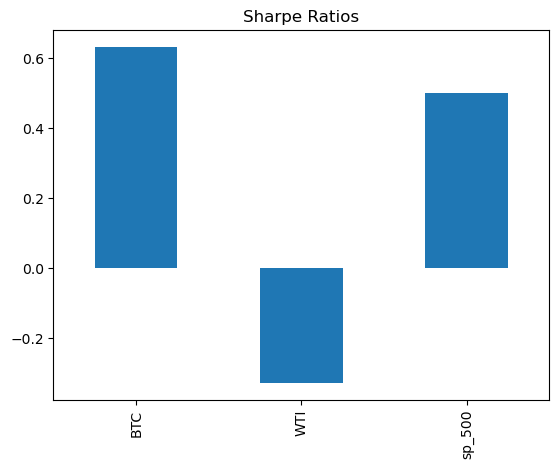

In [18]:
# Annualized Sharpe Ratios
sharpe_ratios = (daily_returns.mean() * 252) / (assets_std * np.sqrt(252))

# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

# Analysis

The S&P 500 has the least volitility as it is representative of the overall market performance. While conventional wisdom says BTC would be the riskier assets, the WTI oil ETF experienced a huge dip in the first half of 2020 (likely from the COVID-19 pandemic). As a reslut, oil ranks higher in volitilty than BTC.

`assets_std = daily_returns.std().sort_values()`

`sp_500    0.013608`

`BTC       0.047675`

`WTI       0.098946`

## Question: Would a portfolio made up of SP500 index fund, BTC and Oil be balanced and perform well over time?
Given the relative level that these assets are uncorrelated, combining them together in a portfolio could be a viable investment strategy. To answer this we ran an Monte Carlos Simulation

In [19]:
combined_df


,sp_500,WTI,BTC,Average_Temp
Date,,,,
2018-10-31,0.010851,-0.013146,-0.002630,12.40
2018-11-01,0.010558,-0.024805,0.009524,16.60
2018-11-02,-0.006317,-0.008636,0.001671,19.00
2018-11-05,0.005600,-0.000634,0.004887,11.00
2018-11-06,0.006259,-0.014105,0.006441,12.95
...,...,...,...,...
2022-10-24,0.011882,-0.005526,0.009029,14.75
2022-10-25,0.016267,0.008749,0.038783,18.80
2022-10-26,-0.007388,0.030356,0.033568,19.40


In [22]:
# Insert Monete Carlos Simulation
asset_df = combined_df.drop(columns=['Average_Temp'])
asset_df

,sp_500,WTI,BTC
Date,,,
2018-10-31,0.010851,-0.013146,-0.002630
2018-11-01,0.010558,-0.024805,0.009524
2018-11-02,-0.006317,-0.008636,0.001671
2018-11-05,0.005600,-0.000634,0.004887
2018-11-06,0.006259,-0.014105,0.006441
...,...,...,...
2022-10-24,0.011882,-0.005526,0.009029
2022-10-25,0.016267,0.008749,0.038783
2022-10-26,-0.007388,0.030356,0.033568


In [24]:
MC_thirty_year = MCSimulation(
   portfolio_data = asset_df,
   weights = [1/3, 1/3, 1/3],
   num_simulation = 500,
   num_trading_days = 252*4
)

IndexError: Too many levels: Index has only 1 level, not 2

In [ ]:
calc_cumulative_return

In [ ]:
plot_simulation

# Future analysis
Markowitz to determine ideal ratio of the assets in a portfolio

# Analysis Summary
- No correlation with market performance and weather
- Some assets' performance correlate with Google Trends sentiment scores, but not reliable indicator of performance
